# 1.0 Load and explore the data

In [46]:
import pandas as pd
activities_df = pd.read_csv('data/extended_activities_TRI001.csv')

# Count the number of activities for each Activity Type
activity_counts = activities_df['Activity Type'].value_counts()
activity_counts

Swim    216
Ride    181
Run     164
Name: Activity Type, dtype: int64

In [47]:
swim_activities = activities_df[activities_df['Activity Type'] == 'Swim']

# Calculate the correlation of 'Real_duration' with other fields in the dataset
correlations = swim_activities.corr()['Moving Time']

# Display the correlations
correlations.sort_values(ascending=False)


/var/folders/pk/jkqf1fd561d112pccy3prkp80000gn/T/ipykernel_24976/305687133.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = swim_activities.corr()['Moving Time']


Moving Time                  1.000000
Distance                     0.980083
Elapsed Time                 0.922694
Elevation Loss               0.657041
Calories                     0.430156
Activity ID                  0.377195
Elevation High               0.344312
Elevation Low                0.321932
Average Speed                0.192896
Relative Effort              0.179290
Max Cadence                  0.109895
Average Elapsed Speed        0.060983
Maximum Pace 2.0 hr          0.030711
Maximum Pace 1.5 hr          0.030152
Average Cadence              0.015301
Max Heart Rate               0.007011
Average Temperature         -0.001798
Dirt Distance               -0.034352
Average Heart Rate          -0.101910
Maximum Pace 1.0 hr         -0.122496
Average Grade               -0.160314
Maximum Pace 30.0min        -0.178081
Maximum Pace 20.0min        -0.180044
Max Grade                   -0.181749
Max Speed                   -0.191963
Elevation Gain              -0.207673
Maximum Pace

Utility function to display results of the model predictions.

In [48]:
import matplotlib.pyplot as plt

def plot_results(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual Moving Time')
    plt.ylabel('Predicted Moving Time')
    plt.title('Actual vs Predicted Moving Time: {}'.format(model_name))
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for reference
    plt.show()

## 2.0 Prepare the data for model training

In [63]:
from pace_curve import PaceCurveAnalyzer

pca = PaceCurveAnalyzer()

# Add the 90 day Pace Curve in place of the single session values
def update_pace(row):
    # create_pace_curve uses row-specific data
    paces = pca.create_pace_curve('Swim', row['Activity Date'], 90)

    row['90 Day Maximum Pace 5s'] = next(pace for duration, pace in paces if duration == 5)
    row['90 Day Maximum Pace 10s'] = next(pace for duration, pace in paces if duration == 10)
    row['90 Day Maximum Pace 30s'] = next(pace for duration, pace in paces if duration == 30)
    row['90 Day Maximum Pace 1.0min'] = next(pace for duration, pace in paces if duration == 60)
    row['90 Day Maximum Pace 5.0min'] = next(pace for duration, pace in paces if duration == 300)
    row['90 Day Maximum Pace 10.0min'] = next(pace for duration, pace in paces if duration == 600)
    row['90 Day Maximum Pace 20.0min'] = next(pace for duration, pace in paces if duration == 1200)
    row['90 Day Maximum Pace 30.0min'] = next(pace for duration, pace in paces if duration == 1800)
    row['90 Day Maximum Pace 1.0 hr'] = next(pace for duration, pace in paces if duration == 3600)
    row['90 Day Maximum Pace 1.5 hr'] = next(pace for duration, pace in paces if duration == 5400)
    row['90 Day Maximum Pace 2.0 hr'] = next(pace for duration, pace in paces if duration == 7200)
    row.fillna(0.0, inplace=True)
    return row

# Remove the fields that are proxies of the target variable 'Moving Time' from the predictors
data = swim_activities.drop(['Elapsed Time', 
                             'Power Count',
                             'Average Elapsed Speed'
                            ], 
                            axis=1)

data = data.apply(update_pace, axis=1)

# Separate out just the competition data (but with the 90 day Pace and Power data) 
# to create a model for predicting race performance
# data[data['Competition'] == True]

# Remove all columns except the target variable 'Moving Time' and the predictors of distance and Pace Curve
data = data[['Moving Time', 
             'Distance', 
             '90 Day Maximum Pace 5s',
             '90 Day Maximum Pace 10s',
             '90 Day Maximum Pace 30s',
             '90 Day Maximum Pace 1.0min',
             '90 Day Maximum Pace 5.0min',
             '90 Day Maximum Pace 10.0min',
             '90 Day Maximum Pace 20.0min',
             '90 Day Maximum Pace 30.0min',
             '90 Day Maximum Pace 1.0 hr',
             '90 Day Maximum Pace 1.5 hr',
             '90 Day Maximum Pace 2.0 hr'
            ]]

"\ndata = data[['Moving Time', \n             'Distance', \n             'Maximum Pace 10s',\n             'Maximum Pace 5s',\n             'Maximum Pace 30s',\n             'Maximum Pace 1.0min',\n             'Maximum Pace 5.0min',\n             'Maximum Pace 10.0min',\n             'Maximum Pace 20.0min',\n             'Maximum Pace 30.0min',\n             'Maximum Pace 1.0 hr',\n             'Maximum Pace 1.5 hr',\n             'Maximum Pace 2.0 hr'\n            ]]\n"

## 3.0 Create models for assessment

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Lowest RMSE found:  188.51808664911923
Best SVR model:  RandomForestRegressor(min_samples_leaf=2, n_estimators=200, random_state=42)
MSE = 46400.453760947516
RMSE = 215.40764554896262


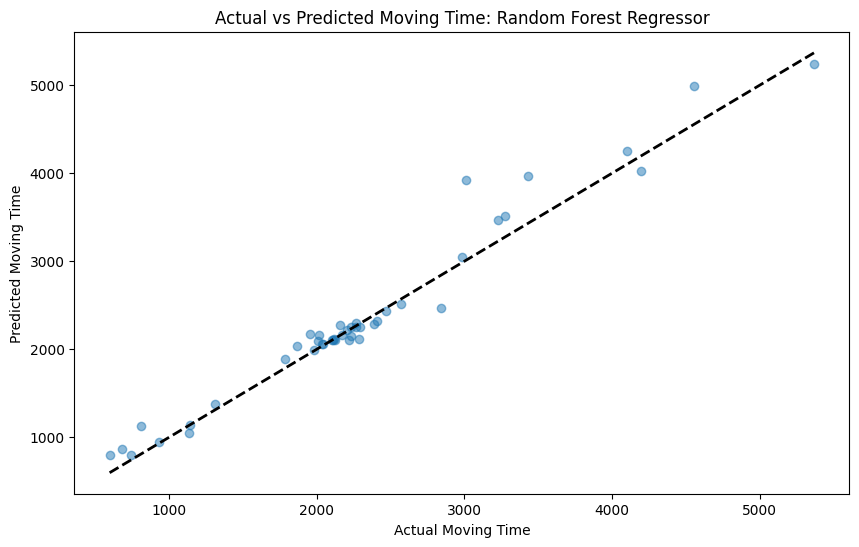

In [80]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import numpy as np

# Preparing the data for the model

# Remove non-numeric data for Random Forest Regressor
data = swim_activities.select_dtypes(include=[np.number])
data = data.fillna(0)

# Removing the target variable 'Moving Time' from the predictors
X = data.drop(['Moving Time',], axis=1)
y = data['Moving Time']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the random forest model
rf_model = RandomForestRegressor(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],     # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],     # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]        # Minimum number of samples required at each leaf node
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                              cv=5, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best estimator
best_rf = grid_search.best_estimator_

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_search.best_score_)))

# Print the complete configuration of the best SVR model
print("Best SVR model: ", grid_search.best_estimator_)

# Predicting on the test set with the best estimator
y_pred = best_rf.predict(X_test)

# Calculating the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print (f'MSE = {mse}')
print (f'RMSE = {np.sqrt(mse)}')

plot_results(y_test, y_pred, 'Random Forest Regressor')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:  {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
Lowest RMSE found:  201.1729672372092
Best SVR model:  SVR(C=100, kernel='linear')
MSE = 107532.68133630707
RMSE = 327.92176099842334


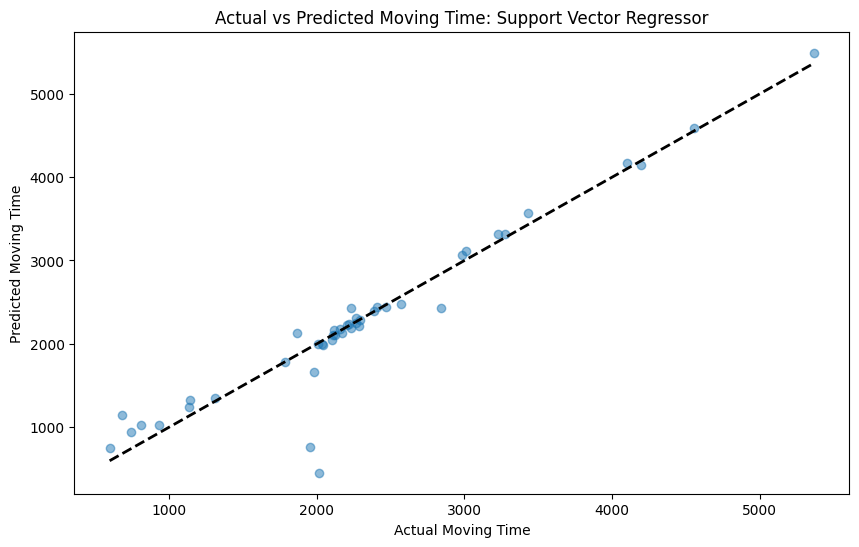

In [36]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import numpy as np

# Removing the target variable 'Moving Time' from the predictors
X = data.drop(['Moving Time',], axis=1)
y = data['Moving Time']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100], 
    'gamma': ['scale', 'auto'], 
    'kernel': ['linear', 'rbf', 'poly']
}

# Creating and training the random forest model
sv_model = SVR()

# Grid search with cross-validation
grid_search = GridSearchCV(sv_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Best estimator
best_svr = grid_search.best_estimator_

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_search.best_score_)))

# Print the complete configuration of the best SVR model
print("Best SVR model: ", grid_search.best_estimator_)

# Predicting on the test set with the best estimator
y_pred = best_svr.predict(X_test)

# Calculating the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print (f'MSE = {mse}')
print (f'RMSE = {np.sqrt(mse)}')

plot_results(y_test, y_pred, 'Support Vector Regressor')

MSE = 200072.68781347256
RMSE = 447.29485556338847


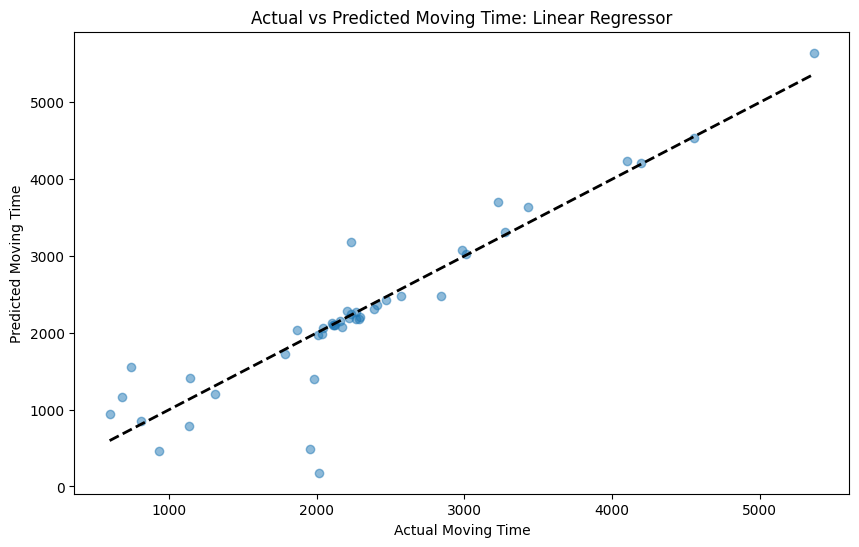

In [37]:
from sklearn.linear_model import LinearRegression

# Removing the target variable 'Moving Time' from the predictors
X = data.drop(['Moving Time',], axis=1)
y = data['Moving Time']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Creating and training the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = lr_model.predict(X_test)

# Calculating the Mean Squared Error for the linear regression model
mse = mean_squared_error(y_test, y_pred)
print (f'MSE = {mse}')
print (f'RMSE = {np.sqrt(mse)}')

plot_results(y_test, y_pred, 'Linear Regressor')

Epoch [100/1500], Loss: 360,851.84
Epoch [200/1500], Loss: 59,183.45
Epoch [300/1500], Loss: 133,730.05
Epoch [400/1500], Loss: 14,170.20
Epoch [500/1500], Loss: 43,435.61
Epoch [600/1500], Loss: 53,003.30
Epoch [700/1500], Loss: 34,801.50
Epoch [800/1500], Loss: 52,385.65
Epoch [900/1500], Loss: 40,008.12
Epoch [1000/1500], Loss: 61,105.78
Epoch [1100/1500], Loss: 9,183.90
Epoch [1200/1500], Loss: 23,464.96
Epoch [1300/1500], Loss: 35,481.88
Epoch [1400/1500], Loss: 11,546.91
Epoch [1500/1500], Loss: 6,981.71


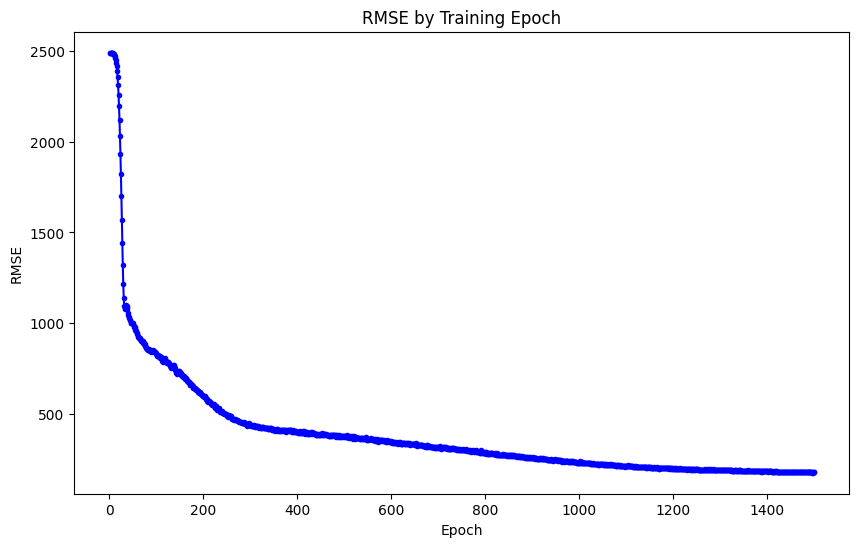

MSE = 32320.1796875
RMSE = 179.77813720703125


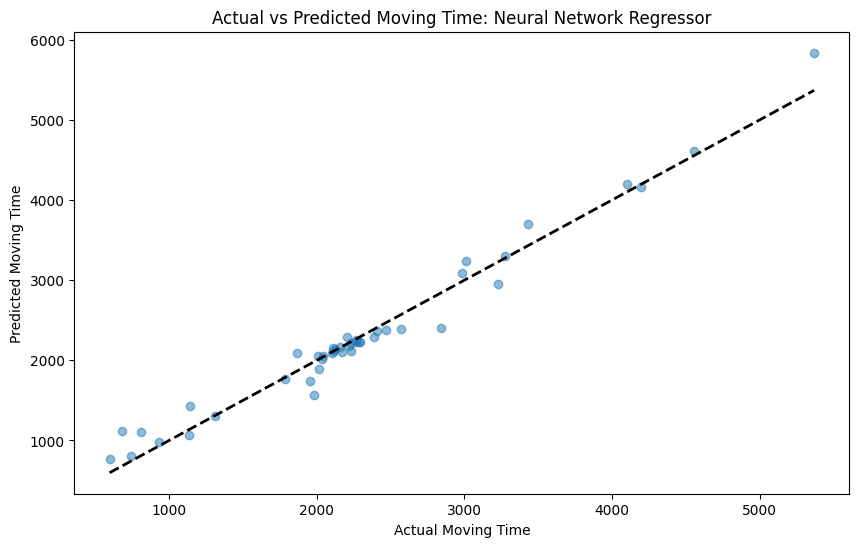

In [83]:
import torch
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.optim as optim

class SwimmingDurationPredictor(nn.Module):
    def __init__(self, input_size):
        super(SwimmingDurationPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # Input layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)         # Hidden layer 1
        self.fc3 = nn.Linear(64, 32)          # Hidden layer 2
        #self.fc4 = nn.Linear(32, 16)          # Hidden layer 2        
        self.fc5 = nn.Linear(32, 1)           # Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        #x = self.fc4(x)
        #x = self.relu(x)
        x = self.fc5(x)
        return x

# Removing the target variable 'Moving Time' from the predictors
X = data.drop(['Moving Time',], axis=1)
y = data['Moving Time']

# Normalize the features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Convert the features and labels to PyTorch tensors
X_tensor = torch.Tensor(X_normalized)
y_tensor = torch.Tensor(y.values)

# Reshape y_tensor to make it two-dimensional (n_samples, 1)
y_tensor = y_tensor.view(y_tensor.shape[0], 1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

model = SwimmingDurationPredictor(X.shape[1])

# Define a loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Number of epochs
num_epochs = 1500

# Convert the training and testing sets to tensor datasets
train_data = torch.utils.data.TensorDataset(X_train, y_train)
test_data = torch.utils.data.TensorDataset(X_test, y_test)

# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=32, shuffle=False)

# List to store RMSE of each epoch
rmse_values = []  

# Training the model
for epoch in range(num_epochs):
    model.train()
    for features, labels in train_loader:
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on test data
    model.eval() 
    with torch.no_grad():
        y_pred = model(X_test).view(-1)
        mse = mean_squared_error(y_test.numpy(), y_pred.numpy())
        rmse = np.sqrt(mse)
        rmse_values.append(rmse)  # Store RMSE for this epoch

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():,.2f}')

# Plot RMSE against epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), rmse_values, marker='.', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE by Training Epoch')
plt.show()

# Evaluation on test data
model.eval() 
with torch.no_grad():
    y_pred = model(X_test).view(-1)

# Calculating the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print (f'MSE = {mse}')
print (f'RMSE = {np.sqrt(mse)}')

plot_results(y_test, y_pred, 'Neural Network Regressor')


/opt/homebrew/Caskroom/miniforge/base/envs/py39tf/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


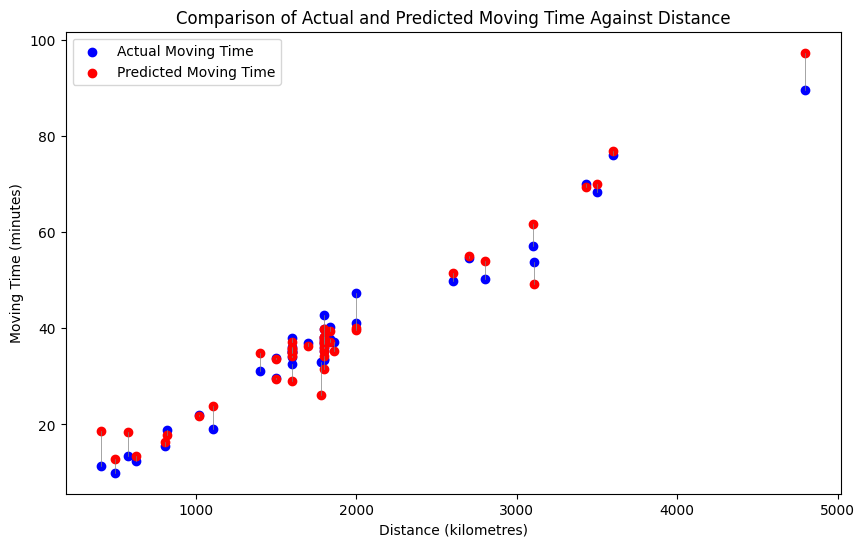

In [84]:
import matplotlib.pyplot as plt
import torch

field = 'Distance'
units = '(kilometres)'

plt.figure(figsize=(10, 6))

column_index = X.columns.get_loc(field)

# Inverse transform the normalized test set
X_test_inverse = scaler.inverse_transform(X_test.numpy())

# Extract the non-normalized values of the desired column
values = X_test_inverse[:, column_index]

# Convert y_test and y_pred from seconds to minutes
y_test_minutes = y_test / 60
y_pred_minutes = y_pred / 60

# Scatter plot of actual values against distance in blue
plt.scatter(values, y_test_minutes, color='blue', label='Actual Moving Time')

# Scatter plot of predicted values against distance in red
plt.scatter(values, y_pred_minutes, color='red', label='Predicted Moving Time')

# Drawing a line between actual and predicted for each point
for d, actual, predicted in zip(values, y_test_minutes, y_pred_minutes):
    plt.plot([d, d], [actual, predicted], color='grey', lw=0.5)  # Line from actual to predicted

plt.xlabel(field + ' ' + units)
plt.ylabel('Moving Time (minutes)')
plt.title(f'Comparison of Actual and Predicted Moving Time Against {field}')
plt.legend()
plt.show()


In [85]:
# Print average for y_pred and y_test
print (f'Average predicted duration = {y_pred.mean()}')
print (f'Average actual duration = {y_test.mean()}')

# Print number of test cases
print (f'Number of test cases = {len(y_test)}')

# Print average difference in seconds per ride
print (f'Average difference in seconds per swim = {abs(y_pred.mean() - y_test.mean())}')

Average predicted duration = 2300.186767578125
Average actual duration = 2287.227294921875
Number of test cases = 44
Average difference in seconds per swim = 12.95947265625
